# Tutorial: Download, pre-process, and analyse HSAF-H60B satellite rainfall observations
This tutorial guides you step by step to:

1. Download the H60B files from the HSAF server.
2. Preprocess the data so it can be used in your analyses (e.g., regridding to latitude/longitude, extracting an area of interest).
3. Analyze rainfall for specific points or an entire region, including visualization and cumulative calculations.

The goal is to help you become familiar with HSAF H60B files.

What is HSAF H60B?
- H60B provides rainfall estimates derived from MSG SEVIRI satellite data.
- The information is updated every 15 minutes for Africa and Europe and has a resolution of 3 x 3 km.

# Step 1: Import the necessary libraries

In [1]:
# Basic libraries
import os
import gzip
import shutil
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd

# Libraries for reprojection (changing geographic coordinate systems)
import rioxarray 
from pyproj import CRS
from pyresample.geometry import AreaDefinition
try:
    from satpy.readers.core._geos_area import get_area_extent
except ImportError:
    from satpy.readers._geos_area import get_area_extent

# Libraries for data and file management
from pathlib import Path
from datetime import datetime, timedelta, date
from ftplib import FTP   # To download files from an FTP server
import re
import warnings

# Suppress/ignore warnings for a cleaner output
warnings.filterwarnings("ignore")

print("All libraries have been successfully imported!")

All libraries have been successfully imported!


# Step 2: Set up data folder structure
Organize the data folder structure using relative paths

In [2]:
# Create folders to save our raw and processed data
data_folder = Path("./h60b_data")
raw_folder = data_folder / "raw"
processed_folder = data_folder / "processed"

# Create the directories if they don’t already exist
raw_folder.mkdir(parents=True, exist_ok=True)
processed_folder.mkdir(parents=True, exist_ok=True)

print("Data folders created:")
print(f"Raw data: {raw_folder}")
print(f"Processed data: {processed_folder}")


Data folders created:
Raw data: h60b_data/raw
Processed data: h60b_data/processed


# Step 3: FTP connection setup
- Please register at https://hsaf.meteoam.it/User/Register to obtain login credentials for the server to download HSAF-H60B data
- Define the FTP server name, the folder path on the FTP server, as well as your username and password
- FTP (File Transfer Protocol) is a protocol that allows file transfers between a local computer and a remote server over the Internet.

In [3]:
# FTP server details for HSAF
ftp_server = "ftphsaf.meteoam.it"
ftp_directory = "./h60B/h60_cur_mon_data/"

# For this tutorial, use your personal HSAF credentials
username = "xxxxxxxxxxx"   		# Replace with your actual username
password = "xxxxxxxxxxx"   	# Replace with your actual password

print(f"FTP Server: {ftp_server}")
print(f"Directory on the FTP server: {ftp_directory}")
print("Note: Don't forget to replace the username/password with your actual HSAF credentials!")

FTP Server: ftphsaf.meteoam.it
Directory on the FTP server: ./h60B/h60_cur_mon_data/
Note: Don't forget to replace the username/password with your actual HSAF credentials!


# Step 4: Connect to the FTP server and list available files
This step is useful to know for which dates there is data available before downloading them.
We use the ftplib library to:
1. Connect to the HSAF FTP server using your credentials
2. Navigate to the directory containing the H60B files
3. List all files available in that directory

In [4]:
def parse_h60b_timestamp(filename):
    """
    Extract the timestamp from an H60B filename.
    
    H60B files available on the HSAF server contain date and time information in their filename in the form: h60B_YYYYMMDD_HHMM_xxx.nc

    This function extracts this information and converts it into a Python datetime object, 
    allowing you to sort files, select time intervals, or perform any other temporal operations in the script.
    """
    try:
        # Split the filename by "_"
        parts = filename.split("_")
        date_str = parts[1]                  # YYYYMMDD
        time_str = parts[2].split(".")[0]    # HHMM
        
        # Combine date and time and convert to a datetime object
        timestamp = datetime.strptime(f"{date_str}{time_str}", "%Y%m%d%H%M")
        return timestamp
    except:
        # If the filename is invalid, return None
        return None

In [5]:
def list_h60b_files_full():
    """
    List all H60B files available on the HSAF FTP server
    and display the first and last available file.

    H60B files on the HSAF server are only kept for the most recent months.
    This function allows you to:
      1. Connect to the HSAF FTP server using your credentials.
      2. List all H60B files in the directory.
      3. Extract the date and time from each filename.
      4. Identify the first and last available file.

    This operation is important to know the data availability period
    before starting an analysis or selecting files for a specific time range.
    """
    try:
        print("Connecting to HSAF FTP server...")
        with FTP(ftp_server) as ftp:
            # Connect using credentials
            ftp.login(username, password)
            print("Connection successful!")
            
            # Navigate to the directory containing H60B files
            ftp.cwd(ftp_directory)
            print(f"Current directory on server: {ftp_directory}")
            
            # Retrieve the list of all files in the directory
            files = []
            ftp.dir(lambda line: files.append(line.split()[-1]))
            
            # Keep only H60B files (starting with 'h60')
            h60b_files = [f for f in files if f.startswith("h60")]
            print(f"{len(h60b_files)} H60B files found on the server")
            
            # Extract timestamps and filter out invalid files
            timestamps_files = [(parse_h60b_timestamp(f), f) 
                                for f in h60b_files 
                                if parse_h60b_timestamp(f) is not None]
            
            if not timestamps_files:
                print("No files with valid timestamps found.")
                return []
            
            # Sort files by ascending timestamp
            timestamps_files.sort()
            
            # Get the first and last file
            first_file = timestamps_files[0]
            last_file  = timestamps_files[-1]
            
            print(f"\nFirst available file: {first_file[1]} ({first_file[0]})")
            print(f"Last available file: {last_file[1]} ({last_file[0]})")
            
            # Return the full sorted list of filenames
            return [f[1] for f in timestamps_files]
    
    except Exception as e:
        print(f"Error during FTP connection: {e}")
        print("Make sure you have registered at https://hsaf.meteoam.it/ and have valid credentials")
        return []


In [6]:
# Apply the functions above to retrieve available files
# We check how many data files are available and the covered period
all_files = list_h60b_files_full()

# Extract timestamps for each file
timestamps_files = [(parse_h60b_timestamp(f), f) for f in all_files if parse_h60b_timestamp(f)]
timestamps_files.sort()  # Sort in ascending order by date

Connecting to HSAF FTP server...
Connection successful!
Current directory on server: ./h60B/h60_cur_mon_data/
6556 H60B files found on the server

First available file: h60_20250328_0000_fdk.nc.gz (2025-03-28 00:00:00)
Last available file: h60_20251010_1145_fdk.nc.gz (2025-10-10 11:45:00)


In [7]:
def select_files_by_steps(start_time, n_steps=1, timestamps_files=timestamps_files):
    """
    Selects a defined number of files starting from a given time.
    
    Parameters:
    - start_time : datetime, the starting time for selection
    - n_steps : int, number of consecutive files to select
    - timestamps_files : list of tuples (timestamp, filename), already sorted by date
    """
    selected_files = []
    last_ts = start_time  # starting point for the search
    
    for _ in range(n_steps):
        next_file = None
        # Find the next available file after last_ts
        for ts, f in timestamps_files:
            if ts >= last_ts:
                next_file = (ts, f)
                break
        
        if next_file:
            selected_files.append(next_file[1])                 # Add the file to the selection
            last_ts = next_file[0] + timedelta(minutes=15)      # Move the threshold just after this file
        else:
            print(f"No file available after {last_ts}")
            break
    
    return selected_files


# Step 5: Selecting a Period for HSAF Data Import
1. We choose a starting moment (`start_datetime`) from which we want to begin retrieving the data.
2. We define the number of consecutive files to retrieve (`n_steps`). Each file corresponds to a 15-minute time step.
3. The `select_files_by_steps` function automatically selects the available files that match this period.

Note: The starting date must be between the first and last file available on the server, which we identified using `list_h60b_files_full()`.

In [8]:
start_datetime = datetime(2025, 10, 8, 15, 0)   # Define the starting time to retrieve HSAF files, Format: datetime(Year, Month, Day, Hour, Minute)
n_steps = 10                                    # Number of files to select, each time step corresponds to 15 minutes

# Select files
selected_files = select_files_by_steps(start_datetime, n_steps)

# Display selected files with their timestamps
print("\nSelected files:")
for f in selected_files:
    ts = parse_h60b_timestamp(f)
    print(f" - {ts} : {f}")


Selected files:
 - 2025-10-08 15:00:00 : h60_20251008_1500_fdk.nc.gz
 - 2025-10-08 15:15:00 : h60_20251008_1515_fdk.nc.gz
 - 2025-10-08 15:30:00 : h60_20251008_1530_fdk.nc.gz
 - 2025-10-08 15:45:00 : h60_20251008_1545_fdk.nc.gz
 - 2025-10-08 16:00:00 : h60_20251008_1600_fdk.nc.gz
 - 2025-10-08 16:15:00 : h60_20251008_1615_fdk.nc.gz
 - 2025-10-08 16:30:00 : h60_20251008_1630_fdk.nc.gz
 - 2025-10-08 16:45:00 : h60_20251008_1645_fdk.nc.gz
 - 2025-10-08 17:00:00 : h60_20251008_1700_fdk.nc.gz
 - 2025-10-08 17:15:00 : h60_20251008_1715_fdk.nc.gz


# Importing and Preprocessing HSAF Data

We will now import HSAF precipitation data from the server. Before we can use and analyze it properly, some preprocessing is required.  
An important step in this preprocessing is, for example, converting a satellite grid into a latitude-longitude (lat-lon) grid, which makes it easier to manipulate and visualize the data.

In this tutorial, we will first work on a single time step.
This allows us to clearly understand each step of the preprocessing. Afterwards, we can apply the same process repeatedly in a loop to pre-process a large number timesteps.

# Step 6: Downloading a Single File
This step shows how to download a specific H60B file from the FTP server:  
1. Check if the file already exists in the local folder to avoid re-downloading.  
2. Download the compressed file (.gz) from the FTP server.  
3. Decompress the file into NetCDF format (.nc).  
4. Delete the compressed file to save disk space.

In [9]:
def download_h60b_file(filename, output_folder=None):
    """Download and decompress a single H60B file"""

    target_folder = Path(output_folder) if output_folder else raw_folder
    target_folder.mkdir(parents=True, exist_ok=True)

    gz_path = target_folder / filename
    nc_path = target_folder / filename.replace(".gz", "")

    # Check if the file already exists locally
    if nc_path.exists():
        print(f"File already exists: {nc_path.name}")
        return str(nc_path)

    try:
        print(f"Downloading {filename}...")

        # Download the compressed file from the FTP server
        with FTP(ftp_server) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_directory)

            with open(gz_path, "wb") as f:
                ftp.retrbinary(f"RETR {filename}", f.write)

        file_size = gz_path.stat().st_size / (1024*1024)  # Size in MB
        print(f"Downloaded {filename} ({file_size:.1f} MB)")

        # Decompress the file
        print(f"Decompressing the file...")
        with gzip.open(gz_path, "rb") as f_in:
            with open(nc_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

        # Delete the compressed file to save disk space
        gz_path.unlink()

        final_size = nc_path.stat().st_size / (1024*1024)  # Final size in MB
        print(f"Decompressed to {nc_path.name} ({final_size:.1f} MB)")

        return str(nc_path)

    except Exception as e:
        print(f"Error downloading {filename}: {e}")
        return None

In [10]:
# Cell: Download a single file by calling the function

if selected_files:
    latest_file = selected_files[-1]                    # Take the most recent file from the availability list
    downloaded_file = download_h60b_file(latest_file)
else:
    print("No files available from the FTP")
    downloaded_file = None

print(downloaded_file)

File already exists: h60_20251008_1715_fdk.nc
h60b_data/raw/h60_20251008_1715_fdk.nc


In the folder `h60b_data/raw/`, you can now check if an HSAF file has been downloaded.

# Step 7: Inspecting the raw H60B Data
1. Check the structure of the H60B file.
2. See which variables and dimensions are available.
3. Examine the precipitation variable 'rr' and its actual values.
4. Review projection information, if available.

In [11]:
def examine_raw_data(filepath):
    """Inspect the structure of a raw H60B file"""
    
    if not filepath or not Path(filepath).exists():
        print("No file available for inspection")
        return None
    
    print(f"Inspecting raw H60B file: {Path(filepath).name}")
    
    # Open the NetCDF dataset with xarray
    ds = xr.open_dataset(filepath, decode_cf=False)
    
    print(f"\nDataset structure:")
    print(f"   Dimensions : {dict(ds.dims)}")        # e.g., time, x, y
    print(f"   Variables : {list(ds.data_vars)}")    # e.g., rr (precipitation)
    print(f"   Coordinates : {list(ds.coords)}")     # e.g., latitude, longitude
    
    # Examine the precipitation variable
    rr = ds['rr']
    print(f"\nPrecipitation variable 'rr':")
    print(f"   Shape : {rr.shape}")
    print(f"   Data type : {rr.dtype}")
    print(f"   Raw values : from {rr.min().values} to {rr.max().values}")
    
    # Check data parameters (scale factor, offset)
    scale_factor = rr.encoding.get('scale_factor', 0.1)
    add_offset = rr.encoding.get('add_offset', 0.0)
    print(f"   Scale factor : {scale_factor}")
    print(f"   Added offset : {add_offset}")
    
    # Compute the precipitation range after applying scale and offset
    rr_scaled = rr.astype('float32') * scale_factor + add_offset  # rr stands for rainfall rate
    print(f"   Actual precipitation range : from {rr_scaled.min().values:.3f} to {rr_scaled.max().values:.3f} mm/h")
    
    # Display projection information if available
    if 'gdal_projection' in ds.attrs:
        print(f"\nProjection : {ds.attrs['gdal_projection']}")
    
    return ds

raw_dataset = examine_raw_data(downloaded_file)


Inspecting raw H60B file: h60_20251008_1715_fdk.nc

Dataset structure:
   Dimensions : {'nx': 3712, 'ny': 3712}
   Variables : ['rr', 'qind', 'geostationary_projection']
   Coordinates : ['nx', 'ny']

Precipitation variable 'rr':
   Shape : (3712, 3712)
   Data type : int16
   Raw values : from -990 to 337
   Scale factor : 0.1
   Added offset : 0.0
   Actual precipitation range : from -99.000 to 33.700 mm/h

Projection : +proj=geos +a=6378169.000000 +b=6356583.800000 +lon_0=0.000000 +h=35785831.000000 +sweep=y


# Step 8: Visualizing Raw Data
To validate the raw data, we will proceed as follows:

1. Plot the precipitation on a map to observe its spatial distribution.
2. Create a histogram to visualize the distribution of rainfall rates.
3. Calculate some basic statistics to understand the intensity and extent of precipitation.

Displaying data for file: h60_20251008_1715_fdk.nc (time: 2025-10-08 17:15)


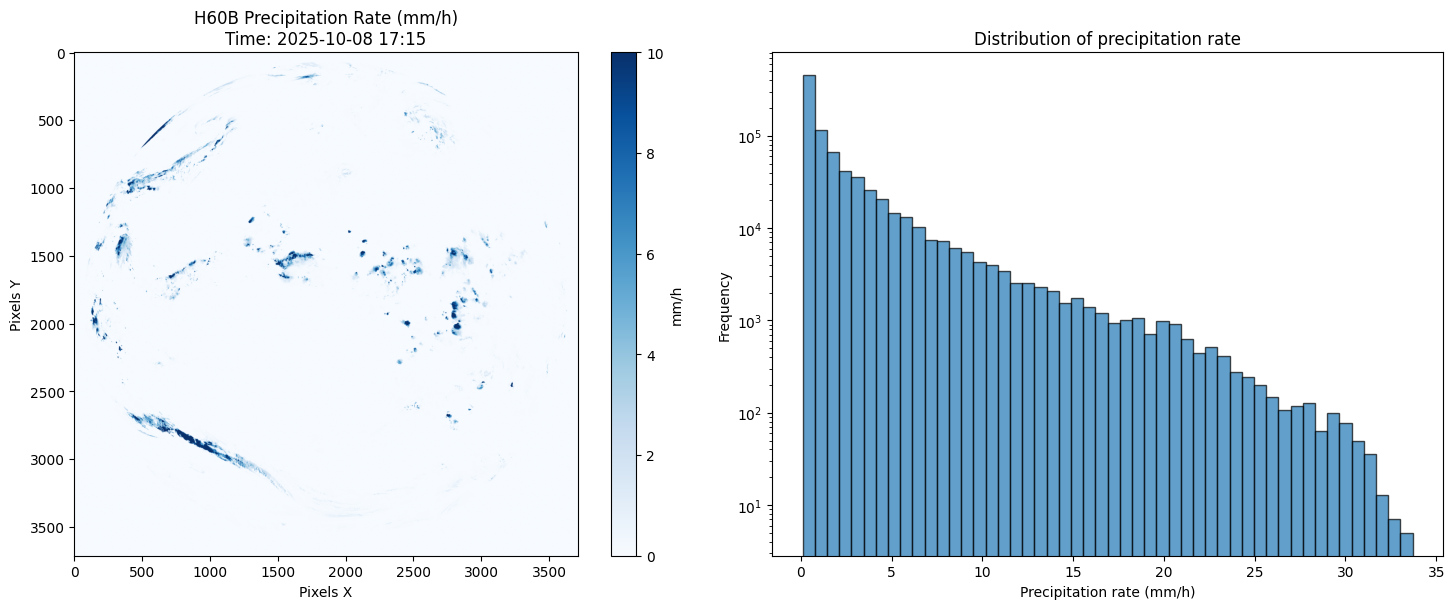


Precipitation statistics:
   Total pixels : 13,778,944
   Pixels with rain (>0 mm/h) : 858,557
   Rain coverage : 8.6%
   Maximum precipitation rate : 33.7 mm/h
   Mean precipitation rate (rainy areas) : 2.00 mm/h


In [12]:
# Cell: Visualizing raw H60B data
import matplotlib.pyplot as plt
import numpy as np
import re
from pathlib import Path

def plot_raw_data(ds, filename=None):
    """Create a simple visualization of raw H60B data"""
    
    if ds is None:
        print("No dataset to display")
        return
    
    # Extract date/time from the filename if provided
    if filename is not None:
        match = re.search(r'(\d{8})_(\d{4})', filename)
        if match:
            date_str, time_str = match.groups()
            timestamp = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]} {time_str[:2]}:{time_str[2:]}"
        else:
            timestamp = "Unknown"
    else:
        timestamp = "Unknown"

    print(f"Displaying data for file: {filename} (time: {timestamp})")

    # Apply scale factor: used for storage reduction, does not affect results
    rr = ds['rr']
    scale_factor = rr.encoding.get('scale_factor', 0.1)
    add_offset = rr.encoding.get('add_offset', 0.0)
    precip = rr.astype('float32') * scale_factor + add_offset
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Precipitation map
    im1 = ax1.imshow(precip.values, cmap='Blues', vmin=0, vmax=10)
    ax1.set_title(f'H60B Precipitation Rate (mm/h)\nTime: {timestamp}')
    ax1.set_xlabel('Pixels X')
    ax1.set_ylabel('Pixels Y')
    plt.colorbar(im1, ax=ax1, label='mm/h')
    
    # Histogram
    valid_precip = precip.values[precip.values >= 0]
    ax2.hist(valid_precip[valid_precip > 0], bins=50, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Precipitation rate (mm/h)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of precipitation rate')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Statistics
    print(f"\nPrecipitation statistics:")
    print(f"   Total pixels : {precip.size:,}")
    print(f"   Pixels with rain (>0 mm/h) : {np.sum(valid_precip > 0):,}")
    print(f"   Rain coverage : {100 * np.sum(valid_precip > 0) / len(valid_precip):.1f}%")
    print(f"   Maximum precipitation rate : {np.max(valid_precip):.1f} mm/h")
    print(f"   Mean precipitation rate (rainy areas) : {np.mean(valid_precip[valid_precip > 0]):.2f} mm/h")

plot_raw_data(raw_dataset, filename=Path(downloaded_file).name)

Note that the satellite grid is in pixels X and Y, not in latitude/longitude.  
Each cell in the H60B file corresponds to a pixel from the satellite sensor.  
If you want to use this data on a geographic map or with QGIS, it is practical to reprojected the data onto a latitude/longitude grid.

# Step 9: Preprocessing Data and reproject onto a Latitude/Longitude Grid

Main steps:
1. Load the raw H60B file.
2. Apply scale factors and rename the precipitation variable.
3. Correctly define the CRS (coordinate reference system).
4. Create consistent spatial coordinates.
5. Reproject the data to WGS84 (latitude/longitude).
6. Set global and variable metadata.
7. Save the NetCDF file in the processed folder.

In [13]:
def preprocess_single_file(raw_file: str, output_folder=None):
    """Preprocess a single H60B file for WGS84 with consistent variable names."""
    
    # Determine target folder for results: the default is processed_folder
    target_folder = Path(output_folder) if output_folder else processed_folder
    target_folder.mkdir(parents=True, exist_ok=True)

    filename = Path(raw_file).name

    # Extract timestamp from filename and define output path
    timestamp = parse_h60b_timestamp(filename)
    hsaf_filename = f"HSAF-H60B_{timestamp.strftime('%Y%m%dT%H%M%S')}.nc"
    output_path = target_folder / hsaf_filename

    # Check if preprocessed file already exists, if it already exists it is not needed to pre-process it again
    if output_path.exists():
        print(f"File already preprocessed: {hsaf_filename} -> Skipping preprocessing")
        return str(output_path)

    print(f"Preprocessing H60B file: {filename} -> {hsaf_filename}")
    
    # Define coordinate systems
    crs_in = "+proj=geos +a=6378.169 +b=6356.584 +h=35785.831 +lat_0=0 +lon_0=0.000000"  # Original CRS (satellite)
    crs_out = "EPSG:4326"  # Output CRS: latitude/longitude

    # Load raw file without automatic CF decoding
    ds = xr.open_dataset(raw_file, decode_coords="all", decode_cf=False)

    # Rename coordinates and apply scale factor
    ds = ds.rename({"nx": "x", "ny": "y"})
    rr_raw = ds["rr"]
    scale_factor = rr_raw.encoding.get("scale_factor", 0.1)
    add_offset  = rr_raw.encoding.get("add_offset", 0.0)
    ds["rr"] = rr_raw.astype("float32") * scale_factor + add_offset
    ds["rr"].encoding.clear()
    ds["rr"].attrs.clear()
    ds = ds[["rr"]].astype("float32")

    # Use CRS directly from file to preserve exact satellite parameters
    source_crs = CRS.from_proj4(ds.attrs["gdal_projection"])
    crs_in = source_crs.to_proj4()
    crs_out = "EPSG:4326"

    # --- Define satellite area extent and coordinates
    cgms_projection = (
        "+proj=geos +coff=1856.000000 +cfac=13642337.000000 "
        "+loff=1856.000000 +lfac=13642337.000000 "
        "+spp=0.000000 +r_eq=6378.169000 +r_pol=6356.583800 +h=42164.000000"
    )
    matches = re.findall(r"\+?(\w+)\s*=\s*([^\s]+)", cgms_projection)
    parse_dict = {k: v for k, v in matches}

    area_extent = get_area_extent({
        "scandir": "N2S",
        "h": float(parse_dict["h"]) * 1000 - float(parse_dict["r_eq"]) * 1000,
        "loff": float(parse_dict["loff"]),
        "coff": float(parse_dict["coff"]),
        "lfac": float(parse_dict["lfac"]),
        "cfac": float(parse_dict["cfac"]),
        "ncols": ds.x.size,
        "nlines": ds.y.size,
    })

    area_def_src = AreaDefinition(
        "areaD",
        source_crs.to_dict()["proj"],
        "areaD",
        {"lon_0": source_crs.to_dict()["lon_0"], "a": source_crs.to_dict()["a"], "b": source_crs.to_dict()["b"], "h": source_crs.to_dict()["h"], "proj": source_crs.to_dict()["proj"]},
        ds.y.size,
        ds.x.size,
        (area_extent[0], area_extent[1], area_extent[2], area_extent[3]),
    )

    # Create new X and Y coordinates
    x, y = area_def_src.get_proj_coords()
    new_x_coords = np.linspace(x.min(), x.max(), num=ds.sizes["x"])
    new_y_coords = np.linspace(y.max(), y.min(), num=ds.sizes["y"])
    ds = ds.assign_coords(y=("y", new_y_coords), x=("x", new_x_coords))

    # Write CRS matching the coordinate units
    ds = ds.rio.write_crs(crs_in)

    # Rename variable, add time, sort dimensions
    ds = ds.rename({"rr": "precip_intensity"}).sortby("y")
    ds = ds.expand_dims("time").assign_coords(time=("time", [timestamp]))
    ds = ds.transpose("time", "y", "x")

    # Set precipitation variable attributes
    ds.precip_intensity.attrs = {
        "standard_name": "precipitation_flux",
        "long_name": "Precipitation flux derived from cloud optical properties",
        "units": "kg m-2 h-1",
    }

    # Replace invalid values with NaN
    ds["precip_intensity"] = ds["precip_intensity"].where(ds["precip_intensity"] >= 0, np.nan)
    da = ds["precip_intensity"].rio.write_nodata(np.nan, encoded=True)
    ds["precip_intensity"] = da

    print("Before reprojection: min/max", float(ds.precip_intensity.min()), float(ds.precip_intensity.max()))

    # Reproject to WGS84
    print("Reprojecting H60B data to WGS84")
    ds = ds.rio.reproject(crs_out, nodata=np.nan)

    print("After reprojection: min/max", float(ds.precip_intensity.min(skipna=True)), float(ds.precip_intensity.max(skipna=True)))

    # Clear encoding after reprojection
    for var_name in ds.data_vars:
        ds[var_name].encoding.clear()
        for attr in ["_FillValue", "missing_value", "fill_value", "FillValue"]:
            ds[var_name].attrs.pop(attr, None)

    # Final dimension order
    ds = ds.transpose("time", "y", "x")

    # Set CF attributes for coordinates
    ds.x.attrs = {"standard_name": "longitude", "long_name": "longitude", "units": "degrees_east", "axis": "X"}
    ds.y.attrs = {"standard_name": "latitude", "long_name": "latitude", "units": "degrees_north", "axis": "Y"}
    ds.time.attrs = {"standard_name": "time", "long_name": "time", "axis": "T"}

    # Set global dataset attributes
    ds.attrs = {
        "Conventions": "CF-1.6",
        "title": "RAINSAT H60B MSG SEVIRI Precipitation",
        "source": "EUMETSAT H-SAF H60B",
        "creator": "HKV services",
        "creation_date": date.today().strftime("%Y-%m-%d"),
        "time_coverage_start": timestamp.strftime("%Y-%m-%dT%H:%M:%S"),
        "time_coverage_end": (timestamp + timedelta(minutes=15)).strftime("%Y-%m-%dT%H:%M:%S"),
        "geospatial_lat_min": float(ds.y.min()),
        "geospatial_lat_max": float(ds.y.max()),
        "geospatial_lon_min": float(ds.x.min()),
        "geospatial_lon_max": float(ds.x.max()),
        "crs": crs_out,
        "product_details": "https://hsaf.meteoam.it/Products/Detail?prod=H60B",
        "data_source": "hsaf-h60b",
    }

    # Encoding for NetCDF
    encoding = {
        "precip_intensity": {"dtype": "float32", "zlib": True, "complevel": 4, "_FillValue": -999.0},
        "time": {"units": "minutes since 1970-01-01 00:00:00", "dtype": "float64"},
    }

    # Save preprocessed NetCDF file
    ds.to_netcdf(output_path, encoding=encoding)
    ds.close()
    print(f"H60B file successfully preprocessed: {hsaf_filename}")
    return str(output_path)

# Run preprocessing for the downloaded file
processed_file = preprocess_single_file(downloaded_file)

File already preprocessed: HSAF-H60B_20251008T171500.nc -> Skipping preprocessing


# Step 10: Visualizing Preprocessed Data in Latitude and Longitude
Now, we will create two plots to analyse the preprocessed data results:  
1. A full precipitation map (mm/h).  
2. A precipitation map which highlights only the rainy areas (> 0.1 mm/h).

At the same time, we will display some statistics to better anlayse the data quality and coverage:  
- The size of the used grid  
- The number of valid pixels  
- The number and coverage of rainy pixels  
- Maximum and mean precipitation intensity in rainy areas

<xarray.Dataset> Size: 55MB
Dimensions:           (x: 3879, y: 3537, time: 1)
Coordinates:
  * x                 (x) float64 31kB -81.26 -81.22 -81.18 ... 81.22 81.26
  * y                 (y) float64 28kB 74.16 74.12 74.07 ... -73.99 -74.03
  * time              (time) datetime64[ns] 8B 2025-10-08T17:15:00
    spatial_ref       int64 8B ...
Data variables:
    precip_intensity  (time, y, x) float32 55MB ...
Attributes: (12/14)
    Conventions:          CF-1.6
    title:                RAINSAT H60B MSG SEVIRI Precipitation
    source:               EUMETSAT H-SAF H60B
    creator:              HKV services
    creation_date:        2025-10-10
    time_coverage_start:  2025-10-08T17:15:00
    ...                   ...
    geospatial_lat_max:   74.15732491263329
    geospatial_lon_min:   -81.25955346826284
    geospatial_lon_max:   81.26224267728661
    crs:                  EPSG:4326
    product_details:      https://hsaf.meteoam.it/Products/Detail?prod=H60B
    data_source:          hs

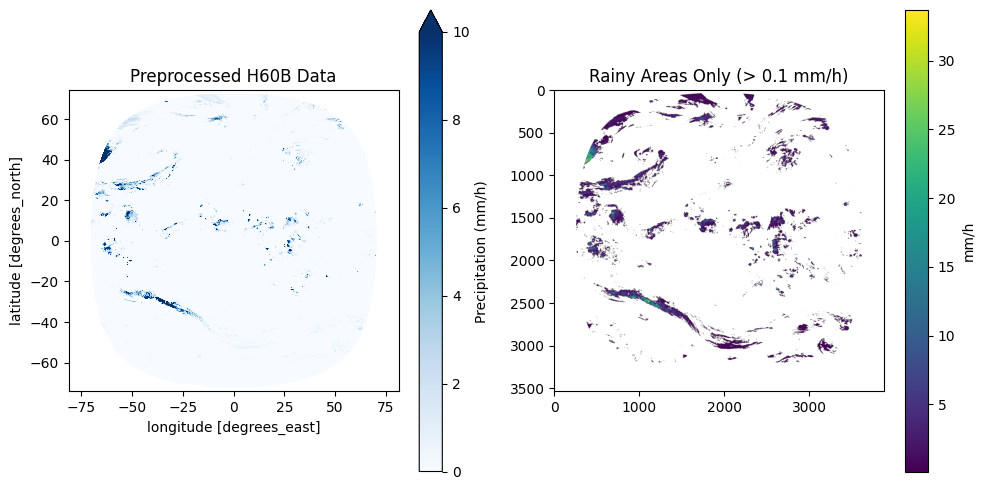


Summary of preprocessed data:
   Time : 2025-10-08T17:15:00.000000000
   Grid size : 3537 x 3879 pixels
   Valid pixels : 10,124,295
   Rainy pixels (>0.1 mm/h) : 773,523
   Rain coverage : 7.64%
   Maximum intensity : 33.7 mm/h
   Mean intensity (rainy areas) : 2.29 mm/h


In [14]:
def plot_processed_data(processed_file):
    """Visualize preprocessed precipitation data"""
    
    # Load the preprocessed NetCDF file
    ds = xr.open_dataset(processed_file)
    print(ds)
    
    # Select the first time step (usually only one for H60B)
    precip = ds["precip_intensity"].isel(time=0)
    
    # Create figure with two side-by-side subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # --- Plot 1: Full precipitation map
    im1 = precip.plot(ax=ax1, cmap='Blues', vmin=0, vmax=10, 
                      cbar_kwargs={'label': 'Precipitation (mm/h)'})
    ax1.set_title('Preprocessed H60B Data')
    ax1.set_aspect('equal')  # Ensure X and Y axes have same scale
    
    # --- Plot 2: Highlight only rainy areas
    rain_mask = precip.values > 0.1  # Areas with > 0.1 mm/h
    if np.any(rain_mask):
        im2 = ax2.imshow(np.where(rain_mask, precip.values, np.nan), 
                         cmap='viridis', vmin=0.1)
        ax2.set_title('Rainy Areas Only (> 0.1 mm/h)')
        plt.colorbar(im2, ax=ax2, label='mm/h')
    else:
        # Display a message if no significant rain
        ax2.text(0.5, 0.5, 'No significant\nrain detected', 
                 ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Rainy Areas Only')
    
    ax2.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    # --- Summary statistics
    valid_data = precip.values[precip.values >= 0]  # Valid pixels
    rainy_data = valid_data[valid_data > 0.1]       # Pixels with rain > 0.1 mm/h
    
    print(f"\nSummary of preprocessed data:")
    print(f"   Time : {ds.time.values[0]}")
    print(f"   Grid size : {precip.shape[0]} x {precip.shape[1]} pixels")
    print(f"   Valid pixels : {len(valid_data):,}")
    print(f"   Rainy pixels (>0.1 mm/h) : {len(rainy_data):,}")
    print(f"   Rain coverage : {100 * len(rainy_data) / len(valid_data):.2f}%")
    
    if len(rainy_data) > 0:
        print(f"   Maximum intensity : {np.max(rainy_data):.1f} mm/h")
        print(f"   Mean intensity (rainy areas) : {np.mean(rainy_data):.2f} mm/h")

# Run visualization if a preprocessed file is available
if processed_file is not None:
    plot_processed_data(processed_file)

Note: You can observe the effect of the re-projecting process. In the left image the data shows a more round data coverage compaired to the raw data visualissation. 

# Step 11: Final Operational Loop
We have now observed in detail how the pre-processing is organized for one single file/timestep. 
The next steps combines all previous steps into a single loop for efficient pre-processing over a number of timesteps:  
1. Download the file from the FTP server  
2. Preprocess the file to convert it into a latitude/longitude grid  
3. Save the processed file to the appropriate folder  


In [15]:
# Earlier in this notebook, you selected a time period of interest for analyzing HSAF data.
# These files will now be used in the following loop. The selected time steps are:
selected_files

['h60_20251008_1500_fdk.nc.gz',
 'h60_20251008_1515_fdk.nc.gz',
 'h60_20251008_1530_fdk.nc.gz',
 'h60_20251008_1545_fdk.nc.gz',
 'h60_20251008_1600_fdk.nc.gz',
 'h60_20251008_1615_fdk.nc.gz',
 'h60_20251008_1630_fdk.nc.gz',
 'h60_20251008_1645_fdk.nc.gz',
 'h60_20251008_1700_fdk.nc.gz',
 'h60_20251008_1715_fdk.nc.gz']

In [16]:
# Final loop to download and preprocess the selected files
for selected_file in selected_files:
    # Determine the path of the downloaded file
    downloaded_file = download_h60b_file(selected_file)
    
    # Extract timestamp from the filename to determine the output file
    timestamp = parse_h60b_timestamp(Path(downloaded_file).name)
    hsaf_filename = f"HSAF-H60B_{timestamp.strftime('%Y%m%dT%H%M%S')}.nc"
    output_path = processed_folder / hsaf_filename

    # Check if the file has already been preprocessed
    if output_path.exists():
        print(f"{hsaf_filename} already exists, skipping to next file\n" + "-"*40)
        continue

    # Preprocess the file
    preprocess_single_file(downloaded_file)
    print(f"{selected_file} processed\n" + "-"*40)

File already exists: h60_20251008_1500_fdk.nc
HSAF-H60B_20251008T150000.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1515_fdk.nc
HSAF-H60B_20251008T151500.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1530_fdk.nc
HSAF-H60B_20251008T153000.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1545_fdk.nc
HSAF-H60B_20251008T154500.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1600_fdk.nc
HSAF-H60B_20251008T160000.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1615_fdk.nc
HSAF-H60B_20251008T161500.nc already exists, skipping to next file
----------------------------------------
File already exists: h60_20251008_1630_fdk.nc
HSAF-H60B_20251008T163000.nc a

We will also download and preprocess additional time steps of HSAF data. These data steps will later be used to validate the nowcast.

In [17]:
# Download and preprocess validation data
nv_raw = Path("nowcast_validation/raw")             # Folder for raw files
nv_processed = Path("nowcast_validation/processed") # Folder for preprocessed files
nv_raw.mkdir(parents=True, exist_ok=True)
nv_processed.mkdir(parents=True, exist_ok=True)

# Define start time for additional files:
# 15 minutes after the last file already selected
extra_start = parse_h60b_timestamp(Path(selected_files[-1]).name) + timedelta(minutes=15)
extra_n_steps = 12   # Number of additional time steps to fetch

# Select additional files starting from the defined time
extra_files = select_files_by_steps(extra_start, extra_n_steps)
print("\nAdditional files (Nowcast):")
for f in extra_files:
    ts = parse_h60b_timestamp(f)
    print(f" - {ts} : {f}")

# --- Loop to download and preprocess Nowcast files ---
for extra_file in extra_files:
    
    # 1. Download the raw H60B file into the Nowcast raw folder
    downloaded_file = download_h60b_file(extra_file, output_folder=nv_raw)
    
    # 2. Determine timestamp and output path for the preprocessed file
    timestamp = parse_h60b_timestamp(Path(downloaded_file).name)
    hsaf_filename = f"HSAF-H60B_{timestamp.strftime('%Y%m%dT%H%M%S')}.nc"
    output_path = nv_processed / hsaf_filename

    # 3. Check if the preprocessed file already exists to avoid duplicates
    if output_path.exists():
        print(f"{hsaf_filename} already exists in nowcast_validation, skipping...\n" + "-"*40)
        continue

    # 4. Preprocess the H60B file and save it to the Nowcast processed folder
    preprocess_single_file(downloaded_file, output_folder=nv_processed)
    print(f"{extra_file} (Nowcast) processed successfully\n" + "-"*40)


Additional files (Nowcast):
 - 2025-10-08 17:30:00 : h60_20251008_1730_fdk.nc.gz
 - 2025-10-08 17:45:00 : h60_20251008_1745_fdk.nc.gz
 - 2025-10-08 18:00:00 : h60_20251008_1800_fdk.nc.gz
 - 2025-10-08 18:15:00 : h60_20251008_1815_fdk.nc.gz
 - 2025-10-08 18:30:00 : h60_20251008_1830_fdk.nc.gz
 - 2025-10-08 18:45:00 : h60_20251008_1845_fdk.nc.gz
 - 2025-10-08 19:00:00 : h60_20251008_1900_fdk.nc.gz
 - 2025-10-08 19:15:00 : h60_20251008_1915_fdk.nc.gz
 - 2025-10-08 19:30:00 : h60_20251008_1930_fdk.nc.gz
 - 2025-10-08 19:45:00 : h60_20251008_1945_fdk.nc.gz
 - 2025-10-08 20:00:00 : h60_20251008_2000_fdk.nc.gz
 - 2025-10-08 20:15:00 : h60_20251008_2015_fdk.nc.gz
File already exists: h60_20251008_1730_fdk.nc
HSAF-H60B_20251008T173000.nc already exists in nowcast_validation, skipping...
----------------------------------------
File already exists: h60_20251008_1745_fdk.nc
HSAF-H60B_20251008T174500.nc already exists in nowcast_validation, skipping...
----------------------------------------
Fil

# Step 12: Selecting and Analyzing HSAF Data for a Specific Area
The HSAF files have been downloaded for a very large area. Now, we will zoom in and analyze the data for a specific area of interest,  
using latitude and longitude coordinates to define your region of interest.

In [18]:
# Available time steps in the folder containing preprocessed HSAF precipitation data.
# You can choose which of these files you want to visualize.

file_list = sorted(processed_folder.glob("HSAF-H60B_*.nc"))
for f in file_list:
    print(f.name)

HSAF-H60B_20250810T080000.nc
HSAF-H60B_20250810T081500.nc
HSAF-H60B_20250810T083000.nc
HSAF-H60B_20250810T084500.nc
HSAF-H60B_20250810T090000.nc
HSAF-H60B_20250810T091500.nc
HSAF-H60B_20250810T093000.nc
HSAF-H60B_20250810T094500.nc
HSAF-H60B_20250810T100000.nc
HSAF-H60B_20250810T101500.nc
HSAF-H60B_20250810T131500.nc
HSAF-H60B_20250810T133000.nc
HSAF-H60B_20250810T134500.nc
HSAF-H60B_20250810T140000.nc
HSAF-H60B_20250810T141500.nc
HSAF-H60B_20250810T143000.nc
HSAF-H60B_20250810T144500.nc
HSAF-H60B_20250810T150000.nc
HSAF-H60B_20250810T151500.nc
HSAF-H60B_20250810T153000.nc
HSAF-H60B_20250826T124500.nc
HSAF-H60B_20250826T130000.nc
HSAF-H60B_20250826T131500.nc
HSAF-H60B_20250826T133000.nc
HSAF-H60B_20250826T134500.nc
HSAF-H60B_20250826T140000.nc
HSAF-H60B_20250826T141500.nc
HSAF-H60B_20250826T143000.nc
HSAF-H60B_20250826T144500.nc
HSAF-H60B_20250826T150000.nc
HSAF-H60B_20250826T151500.nc
HSAF-H60B_20250826T153000.nc
HSAF-H60B_20250830T124500.nc
HSAF-H60B_20250830T130000.nc
HSAF-H60B_2025

In [19]:
# Cell: Plot a subset of H60B data for a specific region
def plot_h60b_subset(processed_folder, filename=None, start_time=None, end_time=None, region=None, max_cols=5):
    """
    Visualize preprocessed H60B data for a given region.
    - filename : display a specific file
    - start_time / end_time : display all time steps in this interval
    - region : dictionary with lat_min, lat_max, lon_min, lon_max
    - max_cols : maximum number of columns per row for subplots
    """
    # Load the dataset
    if filename is not None:
        ds = xr.open_dataset(processed_folder / filename)
    else:
        ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))
    
    # Define the region
    if region is None:
        region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}  # Adjust to your area of interest
    
    ds_roi = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])  # inverted for y
    )
    
    # Filter by time interval
    if start_time is not None and end_time is not None:
        ds_roi = ds_roi.sel(time=slice(start_time, end_time))
    
    # Set bounds and colors for the colormap
    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]  # Precipitation intensity levels
    colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
              "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    # Number of time steps
    n_times = len(ds_roi.time)
    n_cols = min(n_times, max_cols)
    n_rows = math.ceil(n_times / max_cols)
    
    # Create figure with grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = np.array(axes).ravel() 

    # Loop through each time step
    for t in range(n_times):
        ax = axes[t]
        subset = ds_roi.precip_intensity.isel(time=t)
        
        ax.add_feature(cfeature.BORDERS, linewidth=1)
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        
        im = ax.pcolormesh(subset.x, subset.y, subset.values,
                           cmap=cmap, norm=norm, shading='auto')
        cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Precipitation (mm/h)')
        cbar.set_ticks(bounds)
        cbar.set_ticklabels([str(b) for b in bounds])
        
        ax.set_extent([region["lon_min"], region["lon_max"],
                       region["lat_min"], region["lat_max"]])
        
        time_str = np.datetime_as_string(subset.time.values, unit='m')
        ax.set_title(time_str)
    
    # Hide empty axes if fewer subplots than n_rows*n_cols
    for t in range(n_times, n_rows*n_cols):
        axes[t].axis('off')
    
    plt.tight_layout()
    plt.show()

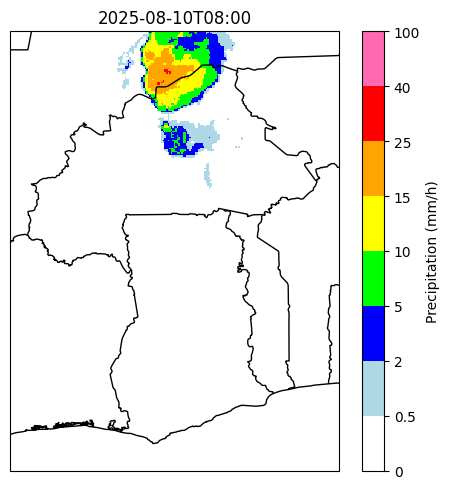

In [20]:
# Here, we call the visualization function for a specific time step.
# Select a time step from the list of files in the processed data folder.
plot_h60b_subset(processed_folder, filename="HSAF-H60B_20250810T080000.nc")

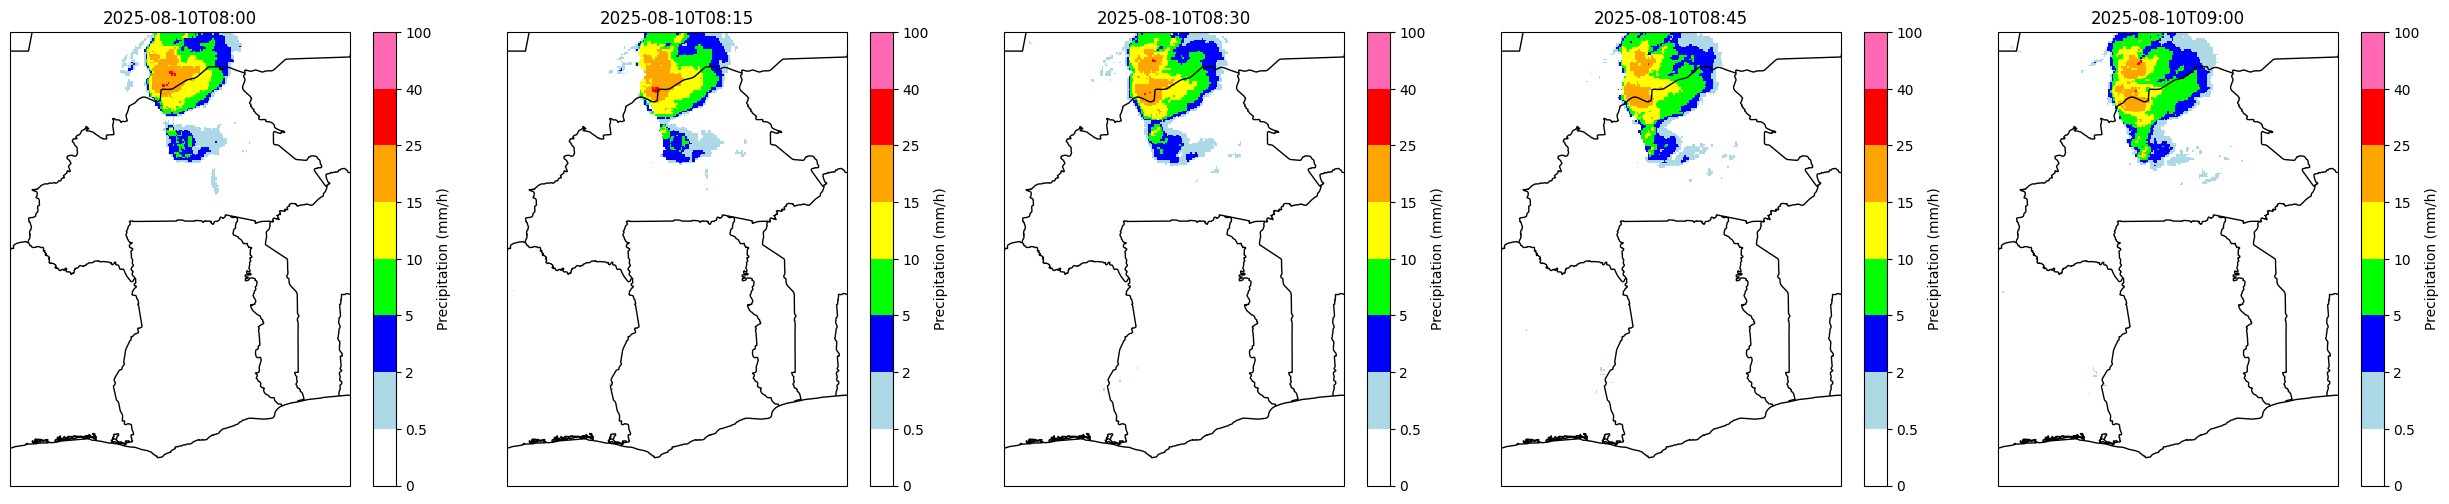

In [21]:
# This command calls the `plot_h60b_subset` function to visualize preprocessed HSAF data for multiple timesteps.
# It will create a visualization for a subset of time steps. Only the time steps within this interval will be displayed.
plot_h60b_subset(
    processed_folder,
    start_time=datetime(2025, 8, 10, 8, 0),
    end_time=datetime(2025, 8, 10, 9, 0)
)


In [22]:
# Cell: Animate H60B precipitation data interactively
def animate_h60b_live(processed_folder, start_time=None, end_time=None, region=None, save_gif=False):
    """
    Display an interactive animation of H60B precipitation for a given time interval.
    The animation is shown in the notebook.
    A fixed point can be added to mark a specific location, for example a city.
    If save_gif=True, the animation is also saved as a GIF in the notebook folder.
    """

    # Load all preprocessed H60B files
    ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))

    if region is None:
        region = {"lat_min": 4, "lat_max": 16, "lon_min": -6, "lon_max": 3}  

    ds_roi = ds.sel(
        x=slice(region["lon_min"], region["lon_max"]),
        y=slice(region["lat_max"], region["lat_min"])
    )

    if start_time is not None and end_time is not None:
        ds_roi = ds_roi.sel(time=slice(start_time, end_time))

    if len(ds_roi.time) == 0:
        print("No data available for the selected interval.")
        return

    bounds = [0, 0.5, 2, 5, 10, 15, 25, 40, 100]
    colors = ["#ffffff", "#add8e6", "#0000ff", "#00ff00",
              "#ffff00", "#ffa500", "#ff0000", "#ff69b4"]

    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Figure and axis
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    plt.close(fig)
    ax.add_feature(cfeature.BORDERS, linewidth=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.set_extent([region["lon_min"], region["lon_max"], region["lat_min"], region["lat_max"]])

    # Optional: specify a fixed point on the map (e.g., measurement site or city)
    # lat_point = 9.961861
    # lon_point = 1.042944
    # ax.plot(lon_point, lat_point, marker='o', color='red', markersize=4, transform=ccrs.PlateCarree(), label='Point of Interest')

    subset0 = ds_roi.precip_intensity.isel(time=0)
    im = ax.pcolormesh(subset0.x, subset0.y, subset0.values,
                       cmap=cmap, norm=norm, shading='auto')
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Precipitation (mm/h)')
    cbar.set_ticks(bounds)
    cbar.set_ticklabels([str(b) for b in bounds])

    def update(frame):
        subset = ds_roi.precip_intensity.isel(time=frame)
        im.set_array(subset.values)
        time_str = np.datetime_as_string(subset.time.values, unit='m')
        ax.set_title(f"H60B Precipitation - {time_str}")
        return [im]

    ani = FuncAnimation(fig, update, frames=len(ds_roi.time), blit=False, interval=1000)

    # --- Optional: save as GIF ---
    if save_gif:
        gif_path = Path("HSAF_H60B_Observations.gif")  
        ani.save(gif_path, writer='pillow', fps=2)
        print(f"Nowcast animation saved as GIF in: {gif_path}")

    return HTML(ani.to_jshtml())

In [23]:
# This command calls the `animate_h60b_live` function to create an animation of preprocessed HSAF data.
# It will display the temporal evolution of precipitation for the selected interval.
# Each frame of the animation corresponds to a time step in this interval, allowing you to visualize the dynamics of rainfall.

animate_h60b_live(
    processed_folder,
    start_time=datetime(2025, 8, 10, 8, 0),
    end_time=datetime(2025, 8, 10, 23, 45),
    save_gif=False
)


<Figure size 640x480 with 0 Axes>

# Step 13: Extract HSAF precipitation for specific points

In [24]:
# 1. Define the folder containing the preprocessed HSAF files
processed_folder = Path("h60b_data/processed/")

# 2. Define points of interest (latitude and longitude)
points = [
    #{"name": "Lomé", "lat": 6.13, "lon": 1.21},
    #{"name": "Ouagadougou", "lat": 12.37, "lon": -1.52},
    {"name": "Nouna", "lat": 12.76, "lon": -3.84},
    {"name": "Kante", "lat": 9.961861, "lon": 1.042944},
    # Add more points if needed
]

# 3. Load all preprocessed HSAF files
ds = xr.open_mfdataset(str(processed_folder / "HSAF-H60B_*.nc"))

# 4. Extract time series for each point
data_dict = {}

for pt in points:
    # Select the nearest pixel to the chosen point
    rain_series = ds.sel(
        x=ds["x"].sel(x=pt["lon"], method="nearest"),
        y=ds["y"].sel(y=pt["lat"], method="nearest")
    )["precip_intensity"]
    
    # Store the series in the dictionary with the point's name
    data_dict[pt["name"]] = rain_series.values

# 5. Create a DataFrame: rows = timestamps, columns = points
df_points = pd.DataFrame(data_dict, index=rain_series["time"].values)
df_points.index.name = "time"  # Name the index for clarity

# 6. Display the final DataFrame
print("Final DataFrame: each column is a point, each row is a timestamp")
df_points

# 7. Save the DataFrame as an Excel file in the notebook folder
# excel_path = Path(".") / "hsaf_points_timeseries.xlsx"
# df_points.to_excel(excel_path, index=True)
# print(f"DataFrame saved to {excel_path}")

df_points

Final DataFrame: each column is a point, each row is a timestamp


,Nouna,Kante
time,,
2025-08-10 08:00:00,0.0,0.0
2025-08-10 08:15:00,0.0,0.0
2025-08-10 08:30:00,0.0,0.0
2025-08-10 08:45:00,0.0,0.0
2025-08-10 09:00:00,0.0,0.0
...,...,...
2025-10-10 10:15:00,0.0,0.0
2025-10-10 10:30:00,0.0,0.0
2025-10-10 10:45:00,0.0,0.0


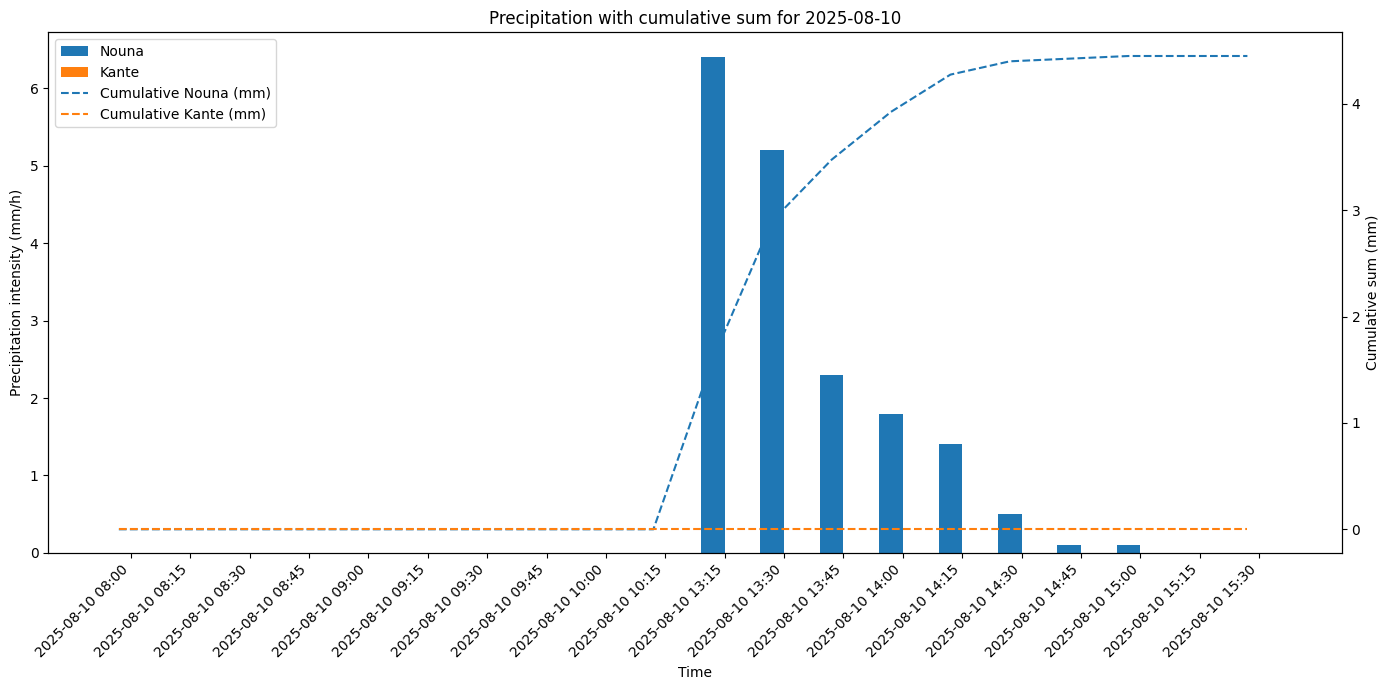

In [25]:
# Define the date to plot
date_to_plot = "2025-08-10"

# Filter the DataFrame for this date
df_date = df_points[df_points.index.date == pd.to_datetime(date_to_plot).date()]

# Create the figure
fig, ax1 = plt.subplots(figsize=(14, 7))

# Create a vector for the X-axis
x = np.arange(len(df_date.index))
n_locations = len(df_date.columns)  # number of locations
width = 0.8 / n_locations  # width of bars distributed among locations

# Loop over all columns (locations)
for i, col in enumerate(df_date.columns):
    # Plot bars for the intensity
    ax1.bar(
        x + i * width,                # offset bars for each location
        df_date[col].values,          # intensity values (mm/h)
        width=width,
        label=col
    )

# Format the X-axis
ax1.set_xticks(x + width * (n_locations - 1) / 2)
ax1.set_xticklabels(df_date.index.strftime("%Y-%m-%d %H:%M"), rotation=45, ha="right")
ax1.set_ylabel("Precipitation intensity (mm/h)")
ax1.set_xlabel("Time")

# Convert to mm per 15-minute step
df_mm = df_date * 0.25  # mm/h * 0.25 = mm/15min

# Add a second Y-axis for cumulative sum
ax2 = ax1.twinx()
for col in df_mm.columns:
    ax2.plot(
        x, 
        df_mm[col].cumsum(), linestyle="--", label=f"Cumulative {col} (mm)"
    )
ax2.set_ylabel("Cumulative sum (mm)")

# Merge legends
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc="upper left")

# Title and layout
plt.title(f"Precipitation with cumulative sum for {date_to_plot}")
plt.tight_layout()
plt.show()

# Congratulations! You’ve successfully completed the workshop🎉